<a href="https://colab.research.google.com/github/Nisarg2104/Automatic-Landcover-Classification-using-Machine-Learning-Techniques/blob/main/LandCoverml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import gdal
from google.colab import files
from matplotlib import pyplot as plt
from PIL import Image
from sklearn import svm
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import preprocessing
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
gdal.UseExceptions()

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
def iou(preds, labels):
    '''
    Takes arrays of shape (num_classes, height, width) [binary masks -> 1 if belonging to class, else 0]
    preds and labels must have same shape
    '''
    h, w = preds.shape[1:3]
    num_classes = preds.shape[0]

    intersection = []
    union = []

    for c in range(num_classes):
        intersection_c = np.sum((np.logical_and(preds[c] == 1, labels[c] == 1)))
        intersection.append(intersection_c)

    for c in range(num_classes):
        union_c = np.sum((np.logical_or(preds[c] == 1, labels[c] == 1)))
        union.append(union_c)

    intersection = np.array(intersection)
    union = np.array(union)
    return intersection / union

In [ ]:
image = gdal.Open('/content/drive/My Drive/PS/data/earth_ndvi_6band/NDVI_v2.tif')
ndvi = image.ReadAsArray()

Exception ignored in: <built-in function delete_Dataset>
RuntimeError: I/O error


In [ ]:
ndvi_flat = ndvi.reshape(ndvi.shape[0], ndvi.shape[1] * ndvi.shape[2]).T
print(ndvi_flat.shape)

(3274869, 6)


In [ ]:
train_y_img = np.array(Image.open('/content/drive/My Drive/LC_agra_z1_sm_rgb.png'))
train_y = np.zeros(train_y_img.shape[:2])
for i in range(train_y_img.shape[0]):
    for j in range(train_y_img.shape[1]):
        if train_y_img[i, j, 0] == 255 and train_y_img[i, j, 2] == 255:
            train_y[i, j] = 4
        elif train_y_img[i, j, 0] == 255:
            train_y[i, j] = 0
        elif train_y_img[i, j, 2] == 255:
            train_y[i, j] = 2
        elif train_y_img[i, j, 1] == 255:
            train_y[i, j] = 1
        else:
            train_y[i, j] = 3
print(train_y.shape)
lc_flat = train_y.reshape(1, train_y.shape[0] * train_y.shape[1]).T
print(lc_flat.shape)
print(np.sum(lc_flat==4))


(1703, 1923)
(3274869, 1)
98188


In [ ]:
image = gdal.Open('/content/drive/My Drive/PS/data/earth_landcover/LC_final_v5_labels.tif')
lc = image.ReadAsArray()
lc = lc - 1 #1,2,3,4 --> 0,1,2,3
#(urban, crop, water, forest)

In [ ]:
lc_flat = lc.reshape(1, lc.shape[0] * lc.shape[1]).T
print(lc_flat)
print(np.sum(lc_flat==4))


[[1]
 [1]
 [1]
 ...
 [1]
 [1]
 [1]]
0


In [ ]:
a=np.arange(1,ndvi_flat.shape[0]+1)
print(a)

[      1       2       3 ... 3274867 3274868 3274869]


In [ ]:
X=pd.DataFrame(data=ndvi_flat[0:,0:],    # values
...              index=a,    # 1st column as index
...              columns=np.array(["month1", "month2","month3","month4","month5","month6"]))
X=preprocessing.scale(X)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


In [ ]:
Y=pd.DataFrame(data=lc_flat[0:,0:],
               index=a,
               columns=np.array(["class"]))

In [ ]:
sk_lda=LinearDiscriminantAnalysis()
X_lda=sk_lda.fit_transform(X,Y)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
print(X_lda)

[[ 0.31472087  0.18661747 -0.26492331 -0.40282004]
 [ 0.09265669  0.25338509 -0.05260241 -1.05724459]
 [ 0.21019689  0.25884443 -0.05921978 -0.97049667]
 ...
 [-1.53481475  0.77494721  1.20741163 -0.47004595]
 [-1.91355333  0.72940346  1.74971248 -0.90973765]
 [-2.65972712  1.02942093  0.35646364 -0.56419601]]


=======================================================================





**Run till here for every classifier.**





=======================================================================

In [ ]:
X_train, X_test, Y_train, Y_test=train_test_split(X_lda,Y, test_size=0.8,random_state=43)
print(X_train.shape,X_lda.shape)

(654973, 4) (3274869, 4)


In [ ]:
clf=svm.LinearSVC(class_weight="balanced")
clf.fit(X_train,Y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight='balanced', dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [ ]:
temp=clf.predict(X_lda)
c=confusion_matrix(Y,temp)
print(sum(c[i][i] for i in range(c.shape[0]))/X_lda.shape[0])

0.8710363681722841


In [ ]:
final=temp.reshape(lc.shape[0],lc.shape[1])

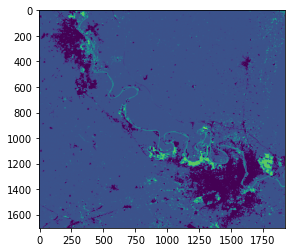

In [ ]:
plt.imshow(final)

In [ ]:
final_img = []
for i in range(3):
    band = (final == i)
    band = np.uint8(band) * 255
    final_img.append(band)
final_img[0] += np.uint8((final == 4)) * 255;
final_img[2] += np.uint8((final == 4)) * 255;
final_img = np.moveaxis(final_img, 0, -1)
final_img = Image.fromarray(final_img)
final_img.save('/content/drive/My Drive/svmAgra6.png')

In [ ]:
final_onehot = []
for i in range(4):
    band = (final == i)
    band = np.uint8(band)
    final_onehot.append(band)
    
train_y = gdal.Open('/content/drive/My Drive/PS/data/earth_landcover/LC_final_v5.tif')
train_y = np.array(train_y.ReadAsArray())
final=np.array(final_onehot)
print(final.shape)
print(train_y.shape)
n=iou(final,train_y)
print(n.mean())

(4, 1703, 1923)
(4, 1703, 1923)
0.4721758514541807


=======================================================================


**SVM OVER DECISION TREE STARTS**


=======================================================================

In [ ]:
X_train, X_test, Y_train, Y_test=train_test_split(X_lda,Y, test_size=0.0000000001,random_state=43)
print(X_train.shape,X_lda.shape)

(3274868, 4) (3274869, 4)


In [ ]:
clf2=tree.DecisionTreeClassifier()
clf2.fit(X_train,Y_train)


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
pred=clf2.predict(X_lda)

In [ ]:
c=confusion_matrix(Y, pred)
print(sum(c[i][i] for i in range(c.shape[0]))/X_lda.shape[0])


0.9977370087169899


95349
[[[  0 255   0]
  [  0 255   0]
  [  0 255   0]
  ...
  [  0 255   0]
  [  0 255   0]
  [  0 255   0]]

 [[  0 255   0]
  [  0 255   0]
  [  0 255   0]
  ...
  [  0 255   0]
  [  0 255   0]
  [  0 255   0]]

 [[  0 255   0]
  [  0 255   0]
  [  0 255   0]
  ...
  [  0 255   0]
  [  0 255   0]
  [  0 255   0]]

 ...

 [[  0 255   0]
  [  0 255   0]
  [  0 255   0]
  ...
  [  0 255   0]
  [  0 255   0]
  [  0 255   0]]

 [[  0 255   0]
  [  0 255   0]
  [  0 255   0]
  ...
  [  0 255   0]
  [  0 255   0]
  [  0 255   0]]

 [[  0 255   0]
  [  0 255   0]
  [  0 255   0]
  ...
  [  0 255   0]
  [  0 255   0]
  [  0 255   0]]]


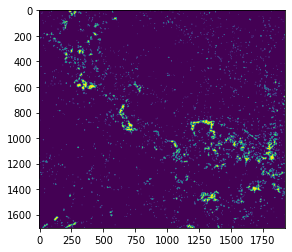

In [ ]:
final=clf2.predict(X_lda).reshape(train_y.shape[0],train_y.shape[1])
print(np.sum(final==4))
plt.imshow(final)
final_img = []
for i in range(3):
    band = (final == i)
    band = np.uint8(band) * 255
    final_img.append(band)
plt.imshow(final==4)
final_img[0] += np.uint8((final == 4)) * 255;
final_img[2] += np.uint8((final == 4)) * 255;
final_img = np.moveaxis(final_img, 0, -1)
print(final_img)
final_img = Image.fromarray(final_img)
final_img.save('/content/drive/My Drive/decisiontreeAgra55.png')


In [ ]:
final_onehot = []
for i in range(4):
    band = (final == i)
    band = np.uint8(band)
    final_onehot.append(band)
    
    
train_y = gdal.Open('/content/drive/My Drive/PS/data/earth_landcover/LC_final_v5.tif')
train_y = np.array(train_y.ReadAsArray())
final=np.array(final_onehot)
print(final.shape)
print(train_y.shape)
n=iou(final,train_y)
print(n.mean())

=======================================================================

DECISION TREE OVER KNN STARTS

=======================================================================

In [ ]:
X_train, X_test, Y_train, Y_test=train_test_split(X_lda,Y, test_size=0.0000000001,random_state=43)
print(X_train.shape,X_lda.shape)

(3274868, 4) (3274869, 4)


In [ ]:
clf3=KNeighborsClassifier(n_neighbors=9)
clf3.fit(X_train,Y_train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=9, p=2,
                     weights='uniform')

In [ ]:
pred=clf3.predict(X_lda)
c=confusion_matrix(Y, pred)
print(sum(c[i][i] for i in range(c.shape[0]))/X_lda.shape[0])

0.9123015302291481


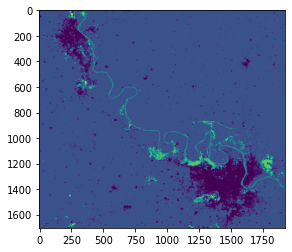

In [ ]:
final=pred.reshape(lc.shape[0],lc.shape[1])
plt.imshow(final)
final_img = []
for i in range(3):
    band = (final == i)
    band = np.uint8(band) * 255
    final_img.append(band)
final_img[0] += np.uint8((final == 4)) * 255;
final_img[2] += np.uint8((final == 4)) * 255;
final_img = np.moveaxis(final_img, 0, -1)
final_img = Image.fromarray(final_img)
final_img.save('/content/drive/My Drive/knnAgra6.png')

In [ ]:
final_onehot = []
for i in range(4):
    band = (final == i)
    band = np.uint8(band)
    final_onehot.append(band)
    
train_y = gdal.Open('/content/drive/My Drive/PS/data/earth_landcover/LC_final_v5.tif')
train_y = np.array(train_y.ReadAsArray())
final=np.array(final_onehot)
print(final.shape)
print(train_y.shape)
n=iou(final,train_y)
print(n.mean())

(4, 1703, 1923)
(4, 1703, 1923)
0.5941019170972391


=======================================================================

KNN OVER Testing STARTS

=======================================================================

In [ ]:
image_test1 = gdal.Open('/content/drive/My Drive/PS/data/Ahmedabad/NDVI_ahmeda_v2.tif')
ndvi_test = image_test1.ReadAsArray()
ndvi_flat_test = ndvi_test.reshape(ndvi_test.shape[0], ndvi_test.shape[1] * ndvi_test.shape[2]).T
image_test2 = gdal.Open('/content/drive/My Drive/PS/data/Ahmedabad/LC_ahmeda_v1_labels.tif')
lc_test = image_test2.ReadAsArray()
lc_test = lc_test - 1 #1,2,3,4 --> 0,1,2,3
#(urban, crop, water, forest)
lc_flat_test = lc_test.reshape(1, lc_test.shape[0] * lc_test.shape[1]).T
a_test=np.arange(1,ndvi_flat_test.shape[0]+1)
print(a_test)


[      1       2       3 ... 3149550 3149551 3149552]


In [ ]:
X_test2=pd.DataFrame(data=ndvi_flat_test[0:,0:],    # values
...              index=a_test,    # 1st column as index
...              columns=np.array(["month1", "month2","month3","month4","month5","month6"]))
X_test2=preprocessing.scale(X_test2)
Y_test2=pd.DataFrame(data=lc_flat_test[0:,0:],
               index=a_test,
               columns=np.array(["class"]))
sk_lda_test=LinearDiscriminantAnalysis()
X_lda_test=sk_lda_test.fit_transform(X_test2,Y_test2)
print(X_lda_test)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[-0.02558801  1.84533356  0.57140599]
 [ 0.073476    2.46290115  0.7686091 ]
 [ 0.19747753  2.25699215  0.38900959]
 ...
 [-0.54598542 -1.00707427 -0.72764425]
 [-0.7553612  -0.45847421 -0.38342115]
 [-1.21552833 -1.17845597 -0.19932806]]


Accuracy of svm= 
0.8741138422226399
(4, 1844, 1708)
(4, 1844, 1708)
iou of svm= 
0.33953776799039964


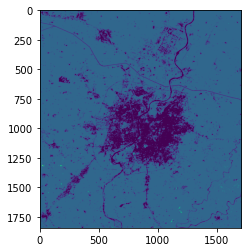

In [ ]:
temp=clf.predict(X_lda_test)
c=confusion_matrix(Y_test2,temp)
print("Accuracy of svm= ")
print(sum(c[i][i] for i in range(c.shape[0]))/X_lda_test.shape[0])
final=temp.reshape(lc_test.shape[0],lc_test.shape[1])
plt.imshow(final)
final_img = []
for i in range(3):
    band = (final == i)
    band = np.uint8(band) * 255
    final_img.append(band)
final_img = np.moveaxis(final_img, 0, -1)
final_img = Image.fromarray(final_img)
final_img.save('/content/drive/My Drive/svmAhmedabad.png')
final_onehot = []
for i in range(4):
    band = (final == i)
    band = np.uint8(band)
    final_onehot.append(band)
    
train_y = gdal.Open('/content/drive/My Drive/PS/data/Ahmedabad/LC_ahmeda_v1.tif')
train_y = np.array(train_y.ReadAsArray())
final=np.array(final_onehot)
print(final.shape)
print(train_y.shape)
n=iou(final,train_y)
print("iou of svm= ")
print(n.mean())

Accuracy of decision tree= 
0.8271805005918302
(4, 1844, 1708)
(4, 1844, 1708)
iou of decision tree= 
0.31331158637220496


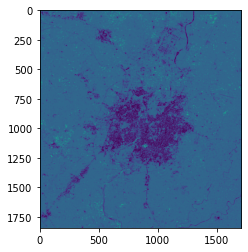

In [ ]:
temp=clf2.predict(X_lda_test)
c=confusion_matrix(Y_test2,temp)
print("Accuracy of decision tree= ")
print(sum(c[i][i] for i in range(c.shape[0]))/X_lda_test.shape[0])
final=temp.reshape(lc_test.shape[0],lc_test.shape[1])
plt.imshow(final)
final_img = []
for i in range(3):
    band = (final == i)
    band = np.uint8(band) * 255
    final_img.append(band)
final_img = np.moveaxis(final_img, 0, -1)
final_img = Image.fromarray(final_img)
final_img.save('/content/drive/My Drive/decisionTreeAhmedabad.png')
final_onehot = []
for i in range(4):
    band = (final == i)
    band = np.uint8(band)
    final_onehot.append(band)
    
train_y = gdal.Open('/content/drive/My Drive/PS/data/Ahmedabad/LC_ahmeda_v1.tif')
train_y = np.array(train_y.ReadAsArray())
final=np.array(final_onehot)
print(final.shape)
print(train_y.shape)
n=iou(final,train_y)
print("iou of decision tree= ")
print(n.mean())

Accuracy of KNN= 
0.8553403785681265
(4, 1844, 1708)
(4, 1844, 1708)
iou of KNN= 
0.3171127342175151


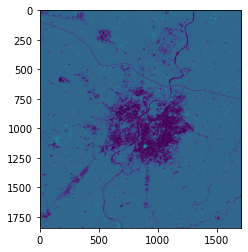

In [ ]:
temp=clf3.predict(X_lda_test)
c=confusion_matrix(Y_test2,temp)
print("Accuracy of KNN= ")
print(sum(c[i][i] for i in range(c.shape[0]))/X_lda_test.shape[0])
final=temp.reshape(lc_test.shape[0],lc_test.shape[1])
plt.imshow(final)
final_img = []
for i in range(3):
    band = (final == i)
    band = np.uint8(band) * 255
    final_img.append(band)
final_img = np.moveaxis(final_img, 0, -1)
final_img = Image.fromarray(final_img)
final_img.save('/content/drive/My Drive/knnAhmedabad.png')
final_onehot = []
for i in range(4):
    band = (final == i)
    band = np.uint8(band)
    final_onehot.append(band)
    
train_y = gdal.Open('/content/drive/My Drive/PS/data/Ahmedabad/LC_ahmeda_v1.tif')
train_y = np.array(train_y.ReadAsArray())
final=np.array(final_onehot)
print(final.shape)
print(train_y.shape)
n=iou(final,train_y)
print("iou of KNN= ")
print(n.mean())